# 5. Matrix Factorization Visualizations

Let m, n be the number of users and movies, respectively, and Y be the m x n matrix of the movie ratings,
where yij corresponds to user i’s rating for the movie j. Note that most of the elements of the matrix are
unknown. The goal of a recommender system is to predict these missing values.
Your job is to find the matrices U and V, such that Y ' UT V . Note that U has dimension k  m and V
has dimension k  n. You must try at least three methods for finding U and V.
1. Use (and/or modify) your code for Homework 5.
2. Incorporate bias terms a and b for each user and movie, to model global tendencies of the various
users and movies. See the guide for more information. You should write your own implementation
of this method.
3. Use an off-the-shelf implementation1. Google ”collaborative filtering python,” ”collaborative filtering
matlab,” etc. to see examples. Note that in this assignment, we want you to try an off-the-shelf matrix
factorization method, rather than any collaborative filtering method in general.

For the first two methods, choose k = 20, and justify your choices for any other parameters and the
stopping criteria you use. For all of these methods, split the MovieLens dataset into a training set (of size
90,000) and a test set (of size 10,000), as given in the files train.txt and test.txt. You should then compare
these methods by assessing their performance on the test set. Once you have obtained U; V , you will
attempt to visualize and interpret your results.
1. In order to visualize the resulting latent factors, apply SVD to V = AB and use the first two columns
of A to project U, V into a two-dimensional space. This projection is given by ~U = AT
1:2U 2 R2m and
~ V = AT
1:2V 2 R2n.
2. Now, construct creative 2D-visualizations of ~ V , similar to the one in Figure 2 of the reference [1]. For
each of the three matrix factorization methods, visualize the following:
(a) Any ten movies of your choice from the MovieLens dataset.
(b) The ten most popular movies (movies which have received the most ratings).
(c) The ten best movies (movies with the highest average ratings).
(d) Ten movies from the three genres you selected in Section 4, Basic Visualizations (for a total of 30
movies). Create one visualization, containing ten movies, for each of the three genres you select.

In [1]:
import sys
sys.path.append('..')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns

from src import utils

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df_data = utils.load_data()
df_train = utils.load_train_data()
df_test = utils.load_test_data()
df_movies = utils.load_movies()

### Homework 5 Question 2 Code

In [3]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    # just use the equation from 2a to compute the gradient of u_i
    first_term = reg * Ui
    second_term = Vj * (Yij - np.dot(Ui, Vj))
    return eta * (first_term - second_term)

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # just use the equation from 2a to compute the gradient of u_i
    first_term = reg * Vj
    second_term = np.multiply(Ui, (Yij - np.dot(Ui, Vj)))
    return eta * (first_term - second_term)

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # find the actual error of the predictions
    total_incorrect = 0.0
    for k in range(np.size(Y, 0)):
        i = int(Y[k, 0])
        j = int(Y[k, 1])
        Y_ij = Y[k, 2]
        # now try to modify both u_i and v_j
        total_incorrect += ((Y_ij - np.dot(U[i, :], V[j, :])) ** 2)
    # multiply by the factor of 0.5
    total_incorrect *= 0.5
    # now find the frobenius norm of U and V
    total_regularized_error = (reg / 2.0) * \
            ((np.linalg.norm(U, ord = 'fro') ** 2) + (np.linalg.norm(V, ord = 'fro') ** 2))
    # now return the entire error
    return total_regularized_error + total_incorrect


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # initial the matrices of U and V to be [-0.5, 0.5]
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5
    # now begin the epochs
    for l in range(max_epochs):
        # quick print statements just to keep track of where we are
        if ((l + 1) % 50 == 0):
            print(f"Currently on epoch #{l + 1}..")
        # store the initial loss
        prev_err = get_err(U, V, Y, reg = reg)
        # shuffle the data initially
        shuffled_Y = np.copy(Y)
        # now perform the actual shuffling
        np.random.shuffle(shuffled_Y)
        # now that the data is shuffled, we can try to adjust the values of U and V
        for k in range(np.size(shuffled_Y, 0)):
            i = int(shuffled_Y[k, 0])
            j = int(shuffled_Y[k, 1])
            Y_ij = shuffled_Y[k, 2]
            # now try to modify both u_i and v_j
            U[i, :] = U[i, :] - grad_U(U[i, :], Y_ij, V[j, :], reg, eta)
            V[j, :] = V[j, :] - grad_V(V[j, :], Y_ij, U[i, :], reg, eta)
        
        # get the new error
        new_err = get_err(U, V, Y, reg = reg)
        loss_drop = prev_err - new_err
        # test the earl stopping condition!
        if (l == 0):
            init_drop = loss_drop
        if (l != 0 and loss_drop / init_drop <= eps):
            print(f"Stopping at epoch #{l + 1}")
            break
                
    print(f"Model training is complete!")
    return U, V, get_err(U, V, Y)

### Actual Visualization Code after Matrix Factorization

In [4]:
# handy function that performs the SVD for V and then gives the 2D projection of V back
def plot_2d_projection_V(V_mat, indices = list(range(10))):
    # first, perform the SVD to get the 2 columns
    A, s, vh = np.linalg.svd(V_mat)
    # get the first two columns
    u_12 = A[:,:2]
    V_bar = np.transpose(np.matmul(u_12.T, V_mat)) # returns an (n by 2) matrix
    
    # TODO: scale the data to be between -1 and 1?

    
    # now perform the actual plotting
    to_plot = V_bar[indices, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for num in range(len(indices)):

        label = f"{indices[num]}"

        plt.annotate(label, # this is the text
                     (to_plot[num, 0],to_plot[num, 1]), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(5,5), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.show()
    return
    

### Data Cleansing

This is essentially the cleansing of the data meant to deal with two main issues:
1) Some movies do not have ratings, this is handled by finding those movies and giving them a default rating of 2.5
2) Some movies have the same title but a different ID, I am not sure exactly what the issue is with this to be totally honest

In [5]:
movie_ids = df_movies.movie_id.values
user_id = np.max(df_data.user_id) + 1
df_train_full = utils.add_missing_ratings(df_train, movie_ids, user_id=user_id)
df_test_full = utils.add_missing_ratings(df_test, movie_ids, user_id=user_id)

In [6]:
# df_data = utils.load_data()
# df_train = utils.load_train_data()
# df_test = utils.load_test_data()
# df_movies = utils.load_movies()

# # initial data cleansing

# # get the raw data in the form of a matrix
# raw_ratings_train = df_train.to_numpy()
# raw_ratings_test = df_test.to_numpy()

# # 1) handle the fact that some movies do not have ratings
# movies_with_ratings = np.unique(raw_ratings_train[:,1])

# max_user_id = max(max(raw_ratings_train[:,0]), max(raw_ratings_test[:,0])).astype(int) # users

# # we know that there are 1682 films
# all_films = np.array(list(range(1, 1683)))

# # loop through all the movies and determine which ones do not have a rating
# for film in movies_with_ratings:
#     all_films[film - 1] = 0
    
# films_without_ratings = np.unique(all_films)

# # we are going to add ratings for all the films without ratings and label this as a rating by an additional user
# # user number 944 to be exact who rates all these 14 missing films with a rating of 2.5
# to_add = []
# for film_wo_rating in films_without_ratings:
#     # filter out the zero that was used to identify all films with ratings
#     if (film_wo_rating == 0):
#         pass
#     else:
#         to_add.append([max_user_id + 1, film_wo_rating, 2.5])
    
# additional_df_train = pd.DataFrame(to_add, columns=list(df_train))
# # append these new default ratings with new default user to the dataframe
# df_train = df_train.append(additional_df_train, ignore_index=True)

# # TODO: handle the cleaning based on the fact that some movies have diff ID's but same title

### Matrix Factorization Visualizations Based on HW 5

In [7]:
Y_train = df_train_full.to_numpy()
Y_test = df_test_full.to_numpy()

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

# just to track runtime warnings
np.seterr(all='raise')
# zero index these
Y_train[:, 0] = Y_train[:, 0] - 1
Y_train[:, 1] = Y_train[:, 1] - 1
Y_test[:, 0] = Y_test[:, 0] - 1
Y_test[:, 1] = Y_test[:, 1] - 1

reg = 0.1
eta = 0.03 # learning rate

# actually run the code
U,V, err = train_model(M, N, K, eta, reg, Y_train)
E_in = err
E_out = get_err(U, V, Y_test)
print(f"The e_in for this factorization is: {E_in: 0.5f}")
print(f"The e_out for this factorization is: {E_out: 0.5f}")



Factorizing with  944  users,  1682  movies.
Stopping at epoch #17
Model training is complete!
The e_in for this factorization is:  27547.32900
The e_out for this factorization is:  7211.11018


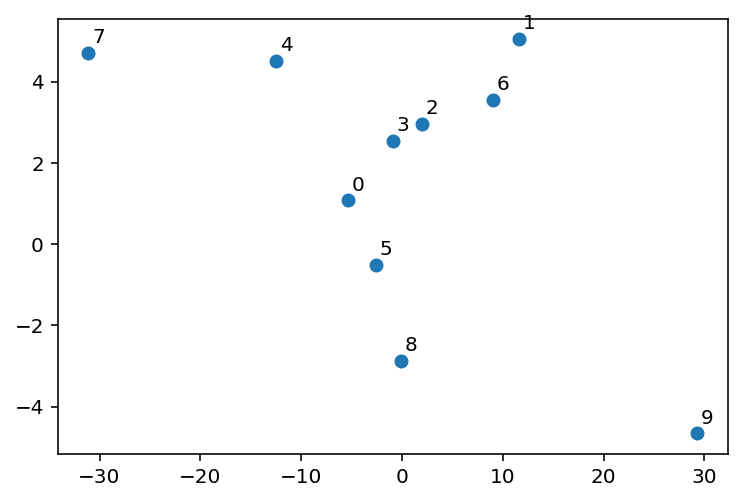

In [8]:
# attempt the visualization
plot_2d_projection_V(V)

### Bias SVD

In [28]:
def grad_U(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    # just use the equation from 2a to compute the gradient of u_i
    first_term = reg * Ui
    second_term = Vj * (Yij - mu - np.dot(Ui, Vj) - ai - bj)
    return eta * (first_term - second_term)

def grad_V(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # just use the equation from 2a to compute the gradient of u_i
    first_term = reg * Vj
    second_term = np.multiply(Ui, (Yij - mu - np.dot(Ui, Vj)) - ai - bj)
    return eta * (first_term - second_term)

def grad_a(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # just use the equation from 2a to compute the gradient of u_i
    first_term = reg * ai
    second_term = Yij - mu - np.dot(Ui, Vj) - ai - bj
    return eta * (first_term - second_term)

def grad_b(Vj, Yij, Ui, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    # just use the equation from 2a to compute the gradient of u_i
    first_term = reg * bj
    second_term = Yij - mu - np.dot(Ui, Vj) - ai - bj
    return eta * (first_term - second_term)

def get_err(U, V, Y, a, b, mu, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # find the actual error of the predictions
    total_incorrect = 0.0
    for k in range(np.size(Y, 0)):
        i = int(Y[k, 0])
        j = int(Y[k, 1])
        Y_ij = Y[k, 2]
        # now try to modify both u_i and v_j
        total_incorrect += ((Y_ij - np.dot(U[i, :], V[j, :]) - mu - a[i] - b[j]) ** 2)
    # multiply by the factor of 0.5
    total_incorrect *= 0.5
    # now find the frobenius norm of U and V
    total_regularized_error = (reg / 2.0) * \
            ((np.linalg.norm(U, ord = 'fro') ** 2) + (np.linalg.norm(V, ord = 'fro') ** 2) \
            + (np.linalg.norm(a) ** 2) + (np.linalg.norm(b) ** 2))
    # now return the entire error
    return total_regularized_error + total_incorrect


def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # initial the matrices of U and V to be [-0.5, 0.5]
    U = np.random.rand(M, K) - 0.5
    V = np.random.rand(N, K) - 0.5
    a = np.zeros(M)
    b = np.zeros(N)
    # get the mean of all recorded ratings
    mu = np.mean(Y[:, 2])
    # now begin the epochs
    for l in range(max_epochs):
        # quick print statements just to keep track of where we are
        if ((l + 1) % 5 == 0):
            print(f"Currently on epoch #{l + 1}..")
        # store the initial loss
        prev_err = get_err(U, V, Y, a, b, mu, reg = reg)
        # shuffle the data initially
        shuffled_Y = np.copy(Y)
        # now perform the actual shuffling
        np.random.shuffle(shuffled_Y)
        # now that the data is shuffled, we can try to adjust the values of U and V
        for k in range(np.size(shuffled_Y, 0)):
            i = int(shuffled_Y[k, 0])
            j = int(shuffled_Y[k, 1])
            Y_ij = shuffled_Y[k, 2]
            # now try to modify both u_i and v_j
            U[i, :] = U[i, :] - grad_U(U[i, :], Y_ij, V[j, :], a[i], b[j], mu, reg, eta)
            V[j, :] = V[j, :] - grad_V(V[j, :], Y_ij, U[i, :], a[i], b[j], mu, reg, eta)
            a[i] = a[i] - grad_a(V[j, :], Y_ij, U[i, :], a[i], b[j], mu, reg, eta)
            b[j] = b[j] - grad_b(V[j, :], Y_ij, U[i, :], a[i], b[j], mu, reg, eta)
        
        # get the new error
        new_err = get_err(U, V, Y, a, b, mu, reg = reg)
        loss_drop = prev_err - new_err
        # test the earl stopping condition!
        if (l == 0):
            init_drop = loss_drop
        if (l != 0 and loss_drop / init_drop <= eps):
            print(f"Stopping at epoch #{l + 1}")
            break
                
    print(f"Model training is complete!")
    return U, V, a, b, get_err(U, V, Y, a, b, mu)

In [29]:
# actually run the bias case
reg = 0.1
eta = 0.03 # learning rate

# actually run the code
U,V, a, b, err = train_model(M, N, K, eta, reg, Y_train, max_epochs = 50)
mu = np.mean(Y_test[:, 2])
E_in = err
E_out = get_err(U, V, Y_test, a, b, mu)
print(f"The e_in for this factorization is: {E_in: 0.5f}")
print(f"The e_out for this factorization is: {E_out: 0.5f}")

Currently on epoch #5..
Currently on epoch #10..
Currently on epoch #15..
Currently on epoch #20..
Currently on epoch #25..
Currently on epoch #30..
Currently on epoch #35..
Currently on epoch #40..
Stopping at epoch #43
Model training is complete!
The e_in for this factorization is:  22167.43715
The e_out for this factorization is:  4200.23281


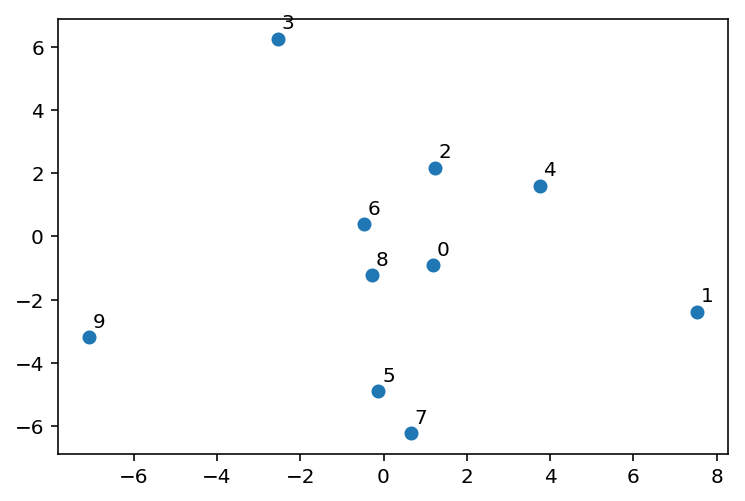

In [31]:
# attempt the visualization
plot_2d_projection_V(V)